# BraTS Data exploration and classification

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Default data paths
from pathlib import Path
from glob import glob
import numpy as np

DATASET = "shapenet"  # "BraTS", "KiTS", "decathlon_lungs", "shapenet"

# To compute mean, std data_utils.compute_data_stats. Here are pre-computed as it takes time.
if DATASET == "BraTS":
    DATASET_BASE_PATH = Path("/home/lorisg96/SE3D/datasets/BraTS")
    MODEL_SAVE_BASE_PATH = Path("/home/lorisg96/SE3D/models/")
    MEAN = np.array([0.04844053, 0.06671674, 0.04088918, 0.04963282])
    STD = np.array([0.11645673, 0.15704592, 0.09690811, 0.12228158])
    FILTER_THRESH = 0.003
    # All samples  (240, 120, 155, 4)
if DATASET == "shapenet":
    DATASET_BASE_PATH = Path("/home/lorisg96/SE3D/datasets/ShapeNetVox32")
    MODEL_SAVE_BASE_PATH = Path("/home/lorisg96/SE3D/models/")
    MEAN = np.array([0.06027088])
    STD = np.array([0.23798802])
    FILTER_THRESH = 0.000
    # All samples  (64, 32, 32, 1)
elif DATASET == "KiTS":
    DATASET_BASE_PATH = Path("/home/lorisg96/SE3D/datasets/KiTS")
    MODEL_SAVE_BASE_PATH = Path("/home/lorisg96/SE3D/models/")
    MEAN = np.array([0.18517924])
    STD = np.array([0.18119358])
    FILTER_THRESH = 0.001
    # Samples between (512, 256, 29, 1) and (512, 398, 1059, 1)
elif DATASET == "decathlon_lungs":
    raise NotImplementedError("Lungs dataset not suitable")
    DATASET_BASE_PATH = Path("/home/lorisg96/SE3D/datasets/decathlon_lungs")
    MODEL_SAVE_BASE_PATH = Path("/home/lorisg96/SE3D/models/")
    MEAN = np.array([0.11019484])
    STD = np.array([0.12821062])
    FILTER_THRESH = 0.003
    # Samples between (512, 256, 112, 1)and (512, 256, 636, 1)
else:
    raise NotImplementedError(f"Invalid dataset {DATASET}")

## Load data


In [4]:
# Load all samples
import data_utils

if DATASET == "BraTS":
    data_list = data_utils.load_BraTS_samples(DATASET_BASE_PATH)
elif DATASET == "KiTS":
    data_list = data_utils.load_KiTS_samples(DATASET_BASE_PATH)
elif DATASET == "decathlon_lungs":
    data_list = data_utils.load_lung_samples(DATASET_BASE_PATH)
elif DATASET == "shapenet":
    class_assignment = data_utils.shapenet_class_dict(DATASET_BASE_PATH / "class_assignment.txt")
    class_list = ["02691156", "02828884"]
    print(f"{[class_assignment[e] for e in class_list]}")
    data_list = data_utils.load_shapenet_pair_samples(DATASET_BASE_PATH, class_list)

print(f"Loaded {len(data_list)} samples")

['airplane\n', 'bench\n']
Loaded 5861 samples


In [5]:
# Add channel dimension if samples don't have one
for sample in data_list:
    if len(sample["image"].shape) == 4:
        break
    sample["image"] = sample["image"][:,:,:,np.newaxis]
    sample["segmentation"] = sample["segmentation"][:,:,:,np.newaxis]
print(f"Last sample shape {sample['image'].shape}")

Last sample shape (64, 32, 32, 1)


In [6]:
# Compute dataset stats if not pre-computed
# import data_utils
# data_utils.compute_data_stats(data_list)

## Data exploration and processing


In [7]:
# What do the segmentations have as max value? Was it already all reduced to 1 type of tumor?
max_seg = 0
for elem in data_list:
    max_seg = max(max_seg, np.max(elem["segmentation"]))
print(f"Maximum value in all segmentations is {max_seg}")

Maximum value in all segmentations is 1


In [8]:
# Do all samples have same shape?
sample_shape = None
min_shape = None
max_shape = None
same = True
for elem in data_list:
    if sample_shape is None: 
        sample_shape=elem["segmentation"].shape
        min_shape=sample_shape
        max_shape=sample_shape
    else:
        if sample_shape != elem["segmentation"].shape:
            same = False
        min_shape = np.min(np.concatenate((np.array(elem["segmentation"].shape)[np.newaxis,:], np.array(min_shape)[np.newaxis,:]), axis=0), 
                           axis=0)
        max_shape = np.max(np.concatenate((np.array(elem["segmentation"].shape)[np.newaxis,:], np.array(max_shape)[np.newaxis,:]), axis=0), 
                           axis=0)
if same:
    print(f"All segmentations have shape {sample_shape}")
    print(f"The images have shape {elem['image'].shape}")
else:
    print("Elements have different shape")
    print(f"Minimum {min_shape}")
    print(f"Maximum {max_shape}")

All segmentations have shape (64, 32, 32, 1)
The images have shape (64, 32, 32, 1)


Positive and negative samples


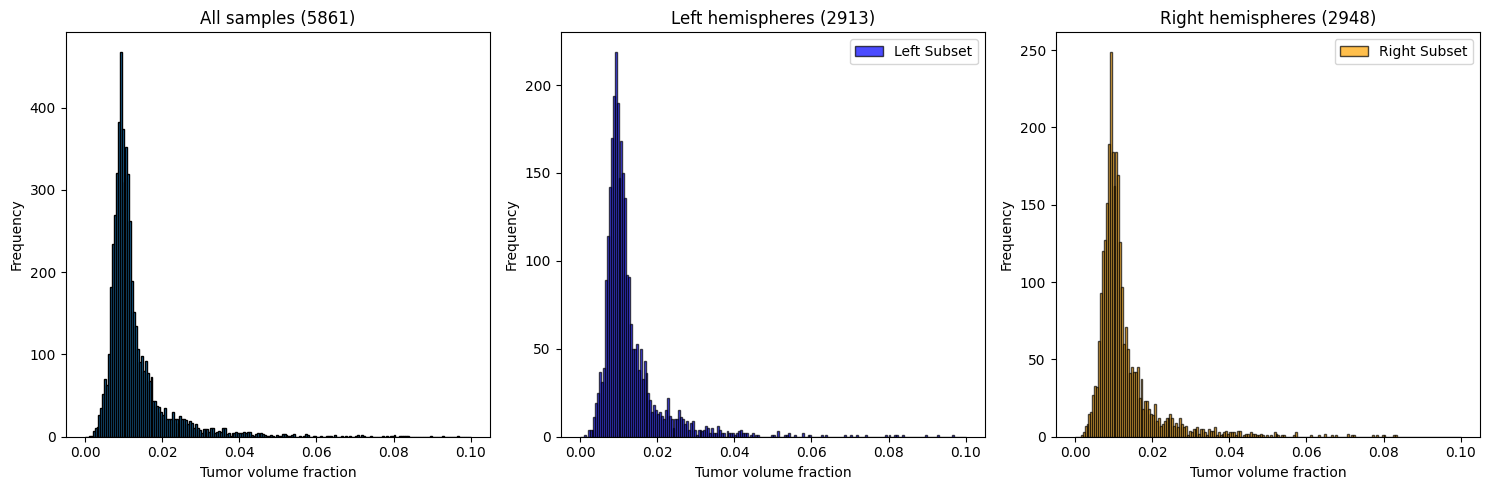

Positive samples only


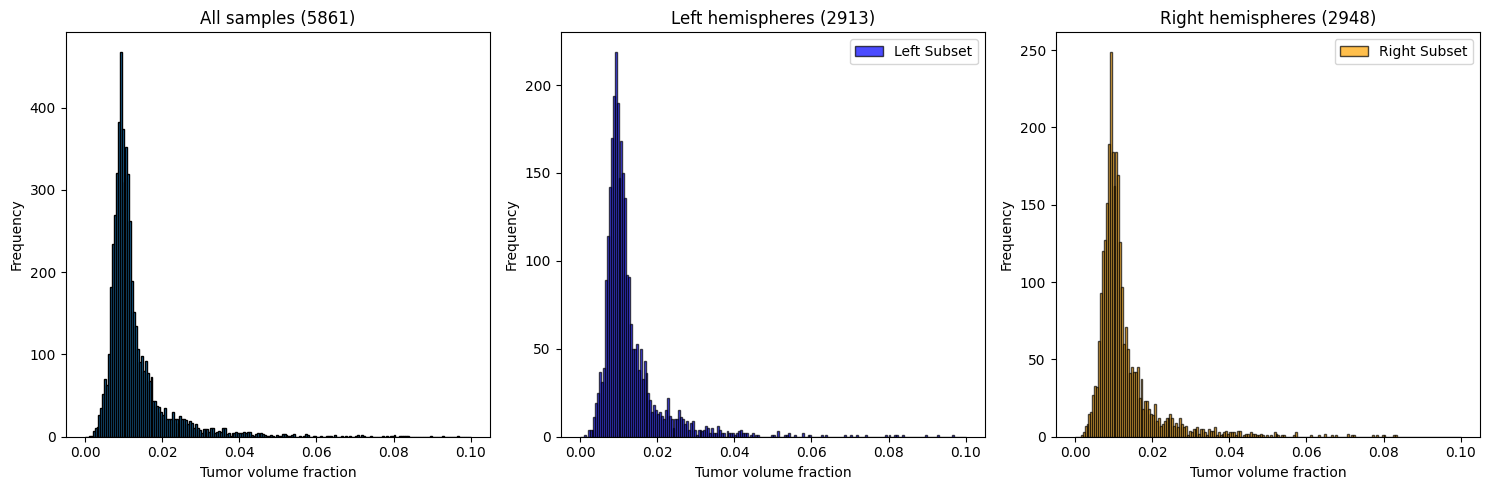

In [9]:
# Histogram of tumor percentages
import matplotlib.pyplot as plt

def plot_percents():
    # Create a layout with one row and three columns
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the histogram for 'percents' on the leftmost subplot
    axs[0].hist(percents, bins=200, range=(0, 0.1), edgecolor='black')
    axs[0].set_title(f'All samples ({len(percents)})')

    # Plot histograms for 'percents_left' and 'percents_right' in the two rightmost subplots
    axs[1].hist(percents_left, bins=200, range=(0, 0.1), color='blue', alpha=0.7, label='Left Subset', edgecolor='black')
    axs[1].set_title(f'Left hemispheres ({len(percents_left)})')
    axs[1].legend()

    axs[2].hist(percents_right, bins=200, range=(0, 0.1), color='orange', alpha=0.7, label='Right Subset', edgecolor='black')
    axs[2].set_title(f'Right hemispheres ({len(percents_right)})')
    axs[2].legend()

    # Add labels and adjust layout
    axs[0].set_xlabel('Tumor volume fraction')
    axs[0].set_ylabel('Frequency')
    axs[1].set_xlabel('Tumor volume fraction')
    axs[1].set_ylabel('Frequency')
    axs[2].set_xlabel('Tumor volume fraction')
    axs[2].set_ylabel('Frequency')

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plots
    plt.show()

# Plot for all samples
print("Positive and negative samples")
percents_left = []
percents_right = []
for elem in data_list:
    value = np.sum(elem["segmentation"])/elem["segmentation"].size
    if elem["side"] == "left":
        percents_left.append(value)
    else:
        percents_right.append(value)

percents = percents_left + percents_right
plot_percents()

# Now repeat but removing all the 0 values
print("Positive samples only")
percents_left = []
percents_right = []
for elem in data_list:
    value = np.sum(elem["segmentation"])/elem["segmentation"].size
    if value > 0:
        if elem["side"] == "left":
            percents_left.append(value)
        else:
            percents_right.append(value)

percents = percents_left + percents_right
plot_percents()

All samples


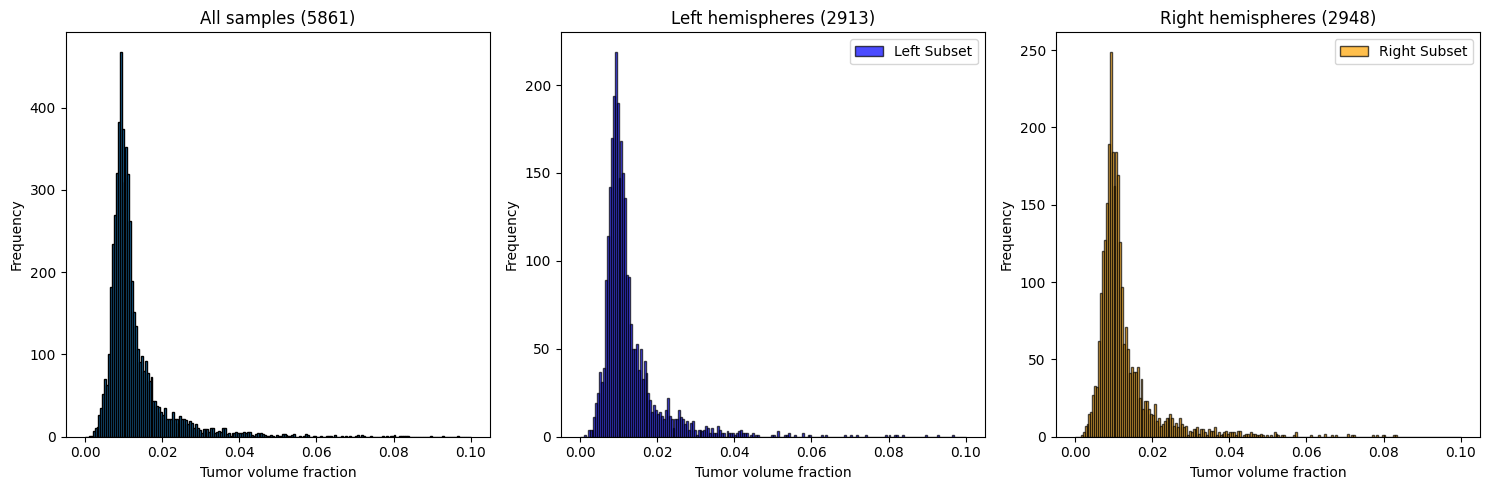

Positive samples only


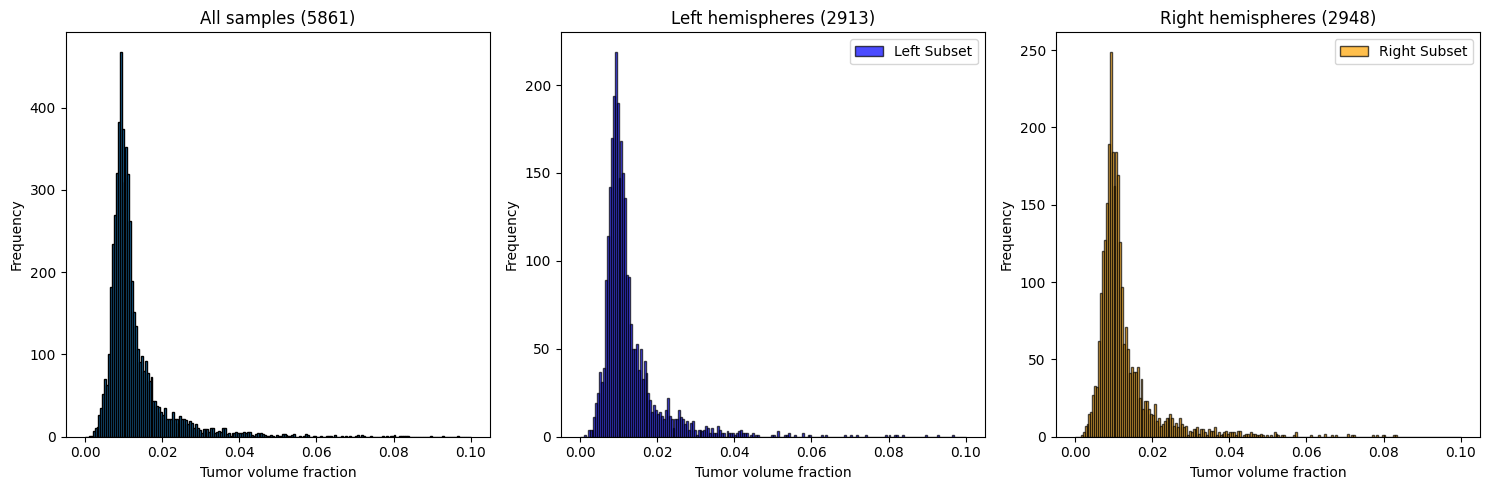

In [10]:
# Removing the borderline cases
from copy import copy, deepcopy
low_thresh_exclusive = 0
high_thresh_inclusive = FILTER_THRESH

# Create new dataset where samples that have a fraction of tumor within (low, high] are removed
# Also plots the new percents
filtered_datalist = []
percents_left = []
percents_right = []

for elem in data_list:
    value = np.sum(elem["segmentation"])/elem["segmentation"].size
    if value <= low_thresh_exclusive or value > high_thresh_inclusive:
        filtered_datalist.append(deepcopy(elem))
        if elem["side"] == "left":
            percents_left.append(value)
        else:
            percents_right.append(value)

percents = percents_left + percents_right
print("All samples")
plot_percents()

# Now repeat but removing all the 0 values
print("Positive samples only")
percents_left = []
percents_right = []
for elem in filtered_datalist:
    value = np.sum(elem["segmentation"])/elem["segmentation"].size
    if value > 0:
        if elem["side"] == "left":
            percents_left.append(value)
        else:
            percents_right.append(value)

percents = percents_left + percents_right
plot_percents()

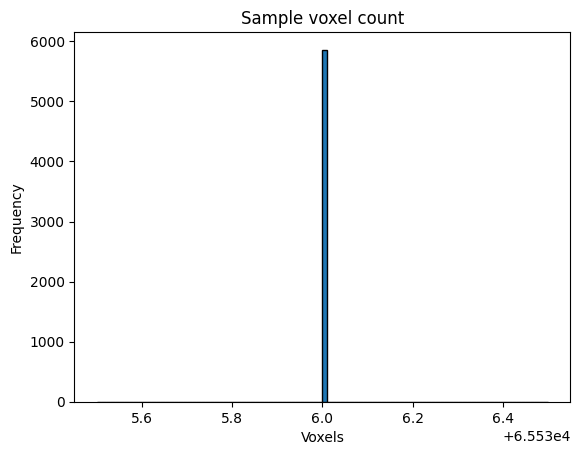

In [11]:
# Plot size distribution of samples
sizes = [e["image"].size for e in filtered_datalist]
plt.hist(sizes, bins=100, range=[min(sizes), max(sizes)], edgecolor='black')

plt.title('Sample voxel count')
plt.xlabel('Voxels')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [12]:
# Filter dataset based on voxel size (large samples don't fit in memory)
SIZE_THRESH = (0.85)*1e8

prev_len = len(filtered_datalist)
filtered_datalist = [e for e in filtered_datalist if e["image"].size <= SIZE_THRESH]
print(f"Filtered elements with size larger than {SIZE_THRESH}, removed {prev_len-len(filtered_datalist)} samples. Remaining {len(filtered_datalist)}")

Filtered elements with size larger than 85000000.0, removed 0 samples. Remaining 5861


In [13]:
# Create labels for the filtered data
if DATASET == "BraTS":
    def brats_labeler(elem):
        value = np.sum(elem["segmentation"])/elem["segmentation"].size
        elem["label"] = value > 0
    
    labeler = brats_labeler
elif DATASET == "shapenet":
    def shapenet_labeler(elem):
        # shapenet already has labels from loader
        pass

    labeler = shapenet_labeler
else:
    raise NotImplementedError(f"No labeler for dataset {DATASET}")

for elem in filtered_datalist:
    labeler(elem)

In [14]:
for elem in data_list:
    print(f"Input shape: {elem['image'].shape}")
    break

Input shape: (64, 32, 32, 1)


In [15]:
# Normalize image data
n_channels = data_list[0]["image"].shape[-1]
labels = []
for elem in filtered_datalist:
    elem["image"] = ((elem["image"].astype(np.double) / 255.0) - MEAN.reshape([1,1,1,n_channels])) / np.sqrt(STD).reshape([1,1,1,n_channels])
    elem["label"] = elem["label"].astype(int)
    labels.append(elem["label"])
print(f"Output shape: {elem['image'].shape}")
print(f"Labels: {labels}")

Output shape: (64, 32, 32, 1)
Labels: [array(0), array(0), array(1), array(1), array(0), array(0), array(1), array(0), array(1), array(0), array(1), array(0), array(0), array(1), array(0), array(1), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(1), array(0), array(0), array(0), array(0), array(0), array(1), array(0), array(0), array(0), array(1), array(0), array(1), array(0), array(0), array(1), array(0), array(1), array(1), array(0), array(1), array(0), array(0), array(1), array(1), array(1), array(0), array(0), array(0), array(0), array(0), array(0), array(1), array(0), array(0), array(0), array(0), array(1), array(1), array(0), array(0), array(1), array(0), array(0), array(0), array(0), array(1), array(0), array(0), array(0), array(0), array(0), array(0), array(1), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(0), array(1), array(0), array(0), array(1), array(0), array(1), array(1), a

In [16]:
# Utilities for dataset folding
def fold_data_list(data_list, n_folds, test_fold, split="train"):
    l = len(data_list)
    fold_size = l//n_folds
    if split=="train":
        return data_list[0:test_fold*fold_size] + data_list[(test_fold+1)*fold_size:]
    else:
        return data_list[test_fold*fold_size:(test_fold+1)*fold_size]

In [17]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ["PATH"] = os.environ["PATH"] + ":/usr/local/cuda/bin"
N_FOLDS = 5
FOLD = 0

# Torch Classification model

In [18]:
# Transpose data to channel first for use with torch
for elem in filtered_datalist:
    if elem["image"].shape[0] == np.min(elem["image"].shape):
        print("Elements already transposed, skipping")
        break
    elem["image"] = np.transpose(elem["image"], [3,0,1,2])
    elem["segmentation"] = np.transpose(elem["segmentation"], [3,0,1,2])
print(f"Output shape: {elem['image'].shape}")

Output shape: (1, 64, 32, 32)


In [19]:
# TORCH
# Define 3D CNN classifier

import torch
import torch.nn as nn
import torch.optim as optim


HIDDEN_DIM = 128
FC_DIM = 512

assert (HIDDEN_DIM%4)==0

class CNN3DModel(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN3DModel, self).__init__()
        
        self.conv1 = nn.Conv3d(in_channels, HIDDEN_DIM//4, kernel_size=3, padding='same')
        self.conv2 = nn.Conv3d(HIDDEN_DIM//4, HIDDEN_DIM//2, kernel_size=3, padding='same')
        self.conv3 = nn.Conv3d(HIDDEN_DIM//2, HIDDEN_DIM, kernel_size=3, padding='same')
        
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        
        self.fc2 = nn.Linear(512, num_classes)

        self.gap = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.gap_fc = nn.Linear(HIDDEN_DIM, FC_DIM)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))

        x = self.gap(x)
        x = x.view(-1, HIDDEN_DIM)
        x = self.relu(self.gap_fc(x))
        x = self.fc2(x)

        # crossentropyloss requires the unscaled logits, so no softmax
        # x = self.relu(x)
        # x = self.softmax(x)
        
        return x

In [20]:
# Create dataloader
from torch.utils.data import Dataset, DataLoader
import torchio as tio

class CustomDataset(Dataset):
    def __init__(self, data_list, n_folds, test_fold):
        self.data = fold_data_list(data_list, n_folds, test_fold, split="train")
        spatial_transforms = {
            tio.RandomElasticDeformation(): 0.2,
            tio.RandomAffine(): 0.8,
        }
        self.transform = tio.Compose([
            tio.OneOf(spatial_transforms, p=0.5),
            tio.RandomFlip(axes="lr", flip_probability=0.5)
            # tio.RescaleIntensity(out_min_max=(0, 1)),
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = torch.tensor(self.data[idx]["image"], dtype=torch.float)
        image = self.transform(image)
        label = torch.tensor(self.data[idx]["label"], dtype=torch.int64)
        return image, label

In [21]:
# Create an instance of your CustomDataset

custom_dataset = CustomDataset(filtered_datalist, N_FOLDS, FOLD)

# Create a DataLoader
batch_size = 1  # Adjust this based on your available resources
train_loader = DataLoader(dataset=custom_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Instantiate model
num_classes = 2

model = CNN3DModel(n_channels, num_classes).cuda()

In [22]:
# Compute class weights
class_counts = {}

# Iterate through the DataLoader to count occurrences of each class
for _, labels in train_loader:
    for label in labels.numpy():
        if label not in class_counts:
            class_counts[label] = 1
        else:
            class_counts[label] += 1

total_samples = sum(class_counts.values())
class_frequencies = {key: value / total_samples for key, value in class_counts.items()}

# Calculate class weights as the inverse of class frequencies
class_weights = {key: 1.0 / value for key, value in class_frequencies.items()}

# Normalize weights so that they sum to the number of classes
sum_weights = sum(class_weights.values())
class_weights_normalized = {key: value / sum_weights for key, value in class_weights.items()}
class_weights_list = [1/class_weights_normalized[x] for x in range(num_classes)]
class_weights_list = [x/sum(class_weights_list) for x in class_weights_list]
class_weights_list = [class_weights_normalized[x] for x in range(num_classes)]

print("Class Counts:", class_counts)
print("Class Weights:", class_weights_list)

/home/lorisg96/miniconda3/lib/python3.11/site-packages/torchio/transforms/augmentation/spatial/random_elastic_deformation.py:303: RuntimeWarning: The maximum displacement is larger than the coarse grid spacing for dimensions: [1, 2], so folding may occur. Choose fewer control points or a smaller maximum displacement
  self.parse_free_form_transform(
/home/lorisg96/miniconda3/lib/python3.11/site-packages/torchio/transforms/augmentation/spatial/random_elastic_deformation.py:303: RuntimeWarning: The maximum displacement is larger than the coarse grid spacing for dimensions: [1, 2], so folding may occur. Choose fewer control points or a smaller maximum displacement
  self.parse_free_form_transform(
/home/lorisg96/miniconda3/lib/python3.11/site-packages/torchio/transforms/augmentation/spatial/random_elastic_deformation.py:303: RuntimeWarning: The maximum displacement is larger than the coarse grid spacing for dimensions: [1, 2], so folding may occur. Choose fewer control points or a smaller

Class Counts: {1: 1452, 0: 3237}
Class Weights: [0.309660908509277, 0.6903390914907229]


In [23]:
# Train model
# Define loss function and optimizer
# from torch.optim.lr_scheduler import CosineAnnealingLR

# training loop
ages = [1]  # [20, 10] for HD 64 or [20] for HD 128
# scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

for idx, epochs in enumerate(ages):
    print(f"Age {idx} with {epochs} epochs")
    criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights_list).cuda())
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)  # 0.0001
    for epoch in range(epochs):
        step=0
        running_loss = 0
        for inputs, labels in train_loader:
            inputs = inputs.cuda()
            labels = labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            step += 1
            print(f'\r Step: {step} Loss: {(running_loss/step):.4f}', end='')
            
        # scheduler.step()
        print(f'\r Epoch [{epoch+1}/{epochs}], Loss: {(running_loss/step):.4f}')

Age 0 with 1 epochs


/home/lorisg96/miniconda3/lib/python3.11/site-packages/torchio/transforms/augmentation/spatial/random_elastic_deformation.py:303: RuntimeWarning: The maximum displacement is larger than the coarse grid spacing for dimensions: [1, 2], so folding may occur. Choose fewer control points or a smaller maximum displacement
  self.parse_free_form_transform(
/home/lorisg96/miniconda3/lib/python3.11/site-packages/torchio/transforms/augmentation/spatial/random_elastic_deformation.py:303: RuntimeWarning: The maximum displacement is larger than the coarse grid spacing for dimensions: [1, 2], so folding may occur. Choose fewer control points or a smaller maximum displacement
  self.parse_free_form_transform(
/home/lorisg96/miniconda3/lib/python3.11/site-packages/torchio/transforms/augmentation/spatial/random_elastic_deformation.py:303: RuntimeWarning: The maximum displacement is larger than the coarse grid spacing for dimensions: [1, 2], so folding may occur. Choose fewer control points or a smaller

 Epoch [1/1], Loss: 0.4034


In [24]:
# Test on training data (no augmentation obvs)
ok = 0
checked = 0
checked_p = 0
checked_n = 0
for sample in fold_data_list(filtered_datalist, N_FOLDS, FOLD, split="test"):
    image_in = torch.tensor(sample["image"], dtype=torch.float).cuda()
    if len(image_in.shape) < 5:
        image_in = image_in.unsqueeze(0)
    model_out = model(image_in).cpu().detach().numpy()
    checked += 1
    checked_p = checked_p + 1 if sample['label'] else checked_p
    checked_n = checked_n + 1 if not sample['label'] else checked_n
    if np.argmax(model_out) == sample['label']:
        ok += 1
    # print(model_out)
    # print(f"Argmax: {np.argmax(model_out)}, label: {sample['label']}")

print(f"Accuracy: {ok/checked}")
print(f"There where {checked_p} positive and {checked_n} negative samples")

Accuracy: 0.9607508532423208
There where 364 positive and 808 negative samples


In [30]:
torch.save(model.state_dict(), MODEL_SAVE_BASE_PATH / f"model_{DATASET}_fold{FOLD}_torch{HIDDEN_DIM}")

# Compute CAMs

In [28]:
from pytorch_grad_cam.grad_cam import GradCAM
from pytorch_grad_cam.hirescam import HiResCAM
from pytorch_grad_cam.grad_cam_plusplus import GradCAMPlusPlus
from pytorch_grad_cam.saliency_tubes import SaliencyTubes
from pytorch_grad_cam.respond_cam import RespondCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [29]:
# print last Conv3D layer
target_layer = model.conv3
cam = GradCAM(model=model, target_layers=[target_layer])
  # TODO change with target label from sample["label"]

In [30]:
sample = fold_data_list(filtered_datalist, N_FOLDS, FOLD, split="test")[8]
image_in = torch.tensor(sample["image"], dtype=torch.float).cuda()

side = sample["side"]
target_label = int(sample["label"])

targets = [ClassifierOutputTarget(target_label)]
grayscale_cam = cam(input_tensor=image_in, targets=targets)
grayscale_cam.shape

(64, 32, 32)

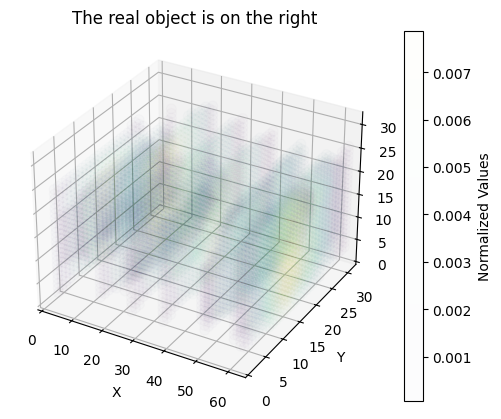

In [50]:
# Plot CAM

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Get the indices of non-zero elements
x, z, y = np.where(grayscale_cam > 0.002)

# Normalize the values between 0 and 1 for colormap
normalized_values = grayscale_cam[x, y, z]

# Plot the voxels with colormap
scatter = ax.scatter(x, y, z, c=normalized_values, cmap='viridis', marker='o', s=50, alpha=0.01)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Normalized Values')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(0,64)
ax.set_ylim(0,32)
ax.set_zlim(0,32)
ax.set_title(f"The real object is on the {side}")

# Show the plot
plt.show()

# Argmax location (is in x y z and not x z y)
# np.unravel_index(grayscale_cam.argmax(), grayscale_cam.shape)

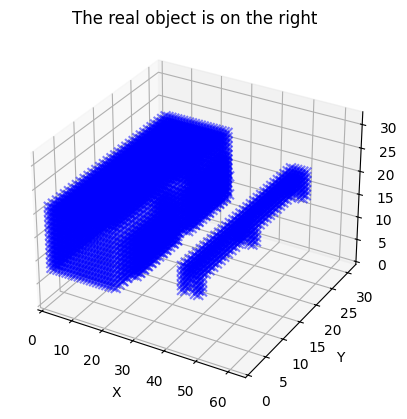

In [51]:
# Plot sample
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Get the indices of non-zero elements (where the voxel is present)
x, z, y = np.where((sample["image"][0]).astype(np.uint8))  # sample["image"][0]

# Plot the voxels
ax.scatter(x, y, z, marker='x', s=50, c='b', alpha=0.5)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(0,64)
ax.set_ylim(0,32)
ax.set_zlim(0,32)

ax.set_title(f"The real object is on the {side}")

# Show the plot
plt.show()

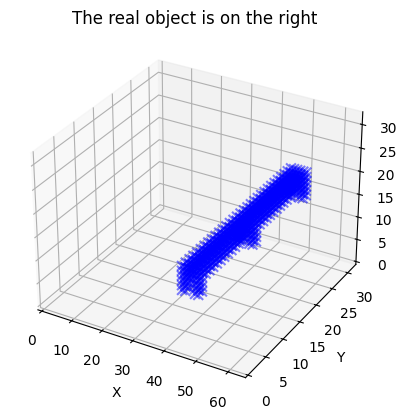

In [52]:
# Plot segmentation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Get the indices of non-zero elements (where the voxel is present)
x, z, y = np.where((sample["segmentation"][0]).astype(np.uint8))  # sample["image"][0]

# Plot the voxels
ax.scatter(x, y, z, marker='x', s=50, c='b', alpha=0.5)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(0,64)
ax.set_ylim(0,32)
ax.set_zlim(0,32)

ax.set_title(f"The real object is on the {side}")

# Show the plot
plt.show()

# Compute MaxBoxAcc


In [113]:
# Define parameters and evaluators
from wsol_3d_metrics.BBoxEvaluator import BBoxEvaluator
from wsol_3d_metrics.BBoxEvaluator3D import BBoxEvaluator3D
from wsol_3d_metrics.MaskEvaluator import MaskEvaluator
from tqdm import tqdm

N_SAMPLES = 100  # Number of samples over which to compute the MaxBoxAcc from the test set
N_THRESH_TAU = 100  # Number of thresholds tau to choose between 0 and 1
DELTA_ACC_THRESH_V1 = [50]  # MaxBoxAcc threshold over which to count the sample as correctly localized
DELTA_ACC_THRESH_V2 = [30,50,70]  # MaxBoxAcc threshold over which to count the sample as correctly localized
METHOD = GradCAM  # Cam method as a class of pytorch_grad_cam
MODEL = model  # Model to compute cam from 
TARGET_LAYER = model.conv3  # Last conv layer to compute cam

thresholds = list(np.linspace(start=0, stop=1, num=N_THRESH_TAU+1, endpoint=False))[1:]  # From 0 to 1 both exclusive
cam = METHOD(model=MODEL, target_layers=[TARGET_LAYER])

MaxBoxAcc_evaluator = BBoxEvaluator(
    iou_threshold_list=DELTA_ACC_THRESH_V1,
    multi_contour_eval=False,
)
MaxBoxAccV2_evaluator = BBoxEvaluator(
    iou_threshold_list=DELTA_ACC_THRESH_V2,
    multi_contour_eval=True,
)
VxAP_evaluator = MaskEvaluator(  # It's the same also as PxAP
    iou_threshold_list=DELTA_ACC_THRESH_V1,
)
Max3DBoxAcc_evaluator = BBoxEvaluator3D(
    iou_threshold_list=DELTA_ACC_THRESH_V1,
    multi_contour_eval=False,
)
Max3DBoxAccV2_evaluator = BBoxEvaluator3D(
    iou_threshold_list=DELTA_ACC_THRESH_V2,
    multi_contour_eval=True,
)

evaluators = [
    {
        "name": "MaxBoxAcc",
        "evaluator_f": MaxBoxAcc_evaluator,
        "3D": False,
    },
    {
        "name": "MaxBoxAccV2",
        "evaluator_f": MaxBoxAccV2_evaluator,
        "3D": False,
    },
    {
        "name": "VxAP",
        "evaluator_f": VxAP_evaluator,
        "3D": True,
    },
    {
        "name": "Max3DBoxAcc",
        "evaluator_f": Max3DBoxAcc_evaluator,
        "3D": True,
    },
    {
        "name": "Max3DBoxAccV2",
        "evaluator_f": Max3DBoxAccV2_evaluator,
        "3D": True,
    },
]

In [110]:
# Compute cams for all samples
all_cams = []
test_samples = fold_data_list(filtered_datalist, N_FOLDS, FOLD, split="test")
if N_SAMPLES < 1:
    N_SAMPLES = len(test_samples)
    print(f"Executing on all {N_SAMPLES} test samples")
if N_SAMPLES > len(test_samples):
    raise ValueError(f"N_SAMPLES={N_SAMPLES} is greater than available samples={len(test_samples)}")
test_samples = test_samples[:N_SAMPLES]
for sample in tqdm(test_samples):
    image_in = torch.tensor(sample["image"], dtype=torch.float).cuda()

    target_label = int(sample["label"])

    targets = [ClassifierOutputTarget(target_label)]
    grayscale_cam = cam(input_tensor=image_in, targets=targets).astype(np.float32)
    normalized_cam = (grayscale_cam - np.min(grayscale_cam))/(np.max(grayscale_cam)-np.min(grayscale_cam))
    all_cams.append(normalized_cam)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:02<00:00, 43.77it/s]


In [114]:
# Compute metrics for computed CAMs
for evaluator in evaluators:
    print(f"Computing {evaluator['name']}")
    # If the evaluator function supports 3D, then call its accumulator function, else call it on each slice
    # NOTE: Due to accumulation over slices, the result may not be a multiple of 1/N_SAMPLES
    if evaluator["3D"]:
        def accumulate(heatmap, mask):
            evaluator["evaluator_f"].accumulate(heatmap, mask)
    else:
        def accumulate(heatmap, mask):
            for i in range(heatmap.shape[-1]):
                evaluator["evaluator_f"].accumulate(heatmap[..., i], mask[..., i])

    for idx, normalized_cam in tqdm(enumerate(all_cams)):
        accumulate(normalized_cam, test_samples[idx]["segmentation"][0].astype(np.float32))

    print(f"{evaluator['name']}: {evaluator['evaluator_f'].compute()}")

Computing MaxBoxAcc


0it [00:00, ?it/s]

100it [00:06, 14.45it/s]


MaxBoxAcc: [0.15625]
Computing MaxBoxAccV2


100it [00:10,  9.87it/s]


MaxBoxAccV2: [4.5, 0.53125, 0.21875]
Computing VxAP


100it [00:00, 347.74it/s]


VxAP: 2.4672956863321223
Computing Max3DBoxAcc


100it [00:20,  4.87it/s]


Max3DBoxAcc: [1.0]
Computing Max3DBoxAccV2


100it [00:20,  4.86it/s]

Max3DBoxAccV2: [8.0, 1.0, 0.0]
